In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_analyze'))  # insert parent path

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#008fd5'
cr = '#fc4f30'

In [2]:
style.set_style()

In [3]:
import statsmodels.tsa.api as smt

# generate some arma data

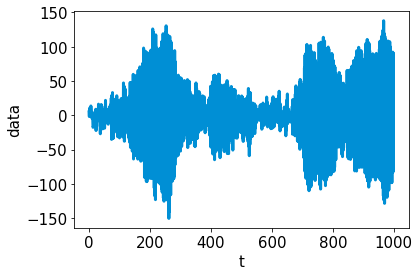

In [9]:
np.random.seed(42)
ar = [1, 0.75, -0.25] # first index is for zero lag
ma = [1, 0.65, 0.35]
n = 1000
sample = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, sigma=10)

plt.plot(sample, color=cb)
plt.xlabel('t')
plt.ylabel('data')
plt.show()

# try to select given p, q based on complexity measure

In [12]:
p, q = 2, 2
m = smt.ARMA(sample, order=(p, q))
results = m.fit(transparams=False)

In [13]:
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(2, 2)   Log Likelihood               -3700.891
Method:                       css-mle   S.D. of innovations              9.774
Date:                Sun, 24 Nov 2019   AIC                           7413.783
Time:                        12:36:58   BIC                           7443.229
Sample:                             0   HQIC                          7424.975
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2560      0.418      0.612      0.541      -0.563       1.075
ar.L1.y       -0.6994      0.060    -11.728      0.000      -0.816      -0.582
ar.L2.y        0.2954      0.060      4.958      0.0

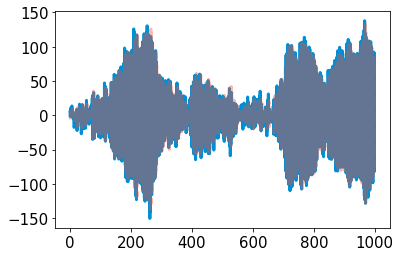

In [18]:
plt.plot(sample, color=cb, label='data')
plt.plot(results.fittedvalues, color=cr, linestyle='--', alpha=0.4, label='fitted')
plt.xlabel('t')
plt.legend()